In [1]:
!pip install numpy==1.26.4
!pip install tensorflow tensorflow-datasets --upgrade


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2025-04-18 16:46:26.584097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 16:46:26.589047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 16:46:26.593246: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 16:46:26.604181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745009186.621758  608303 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745009186.62

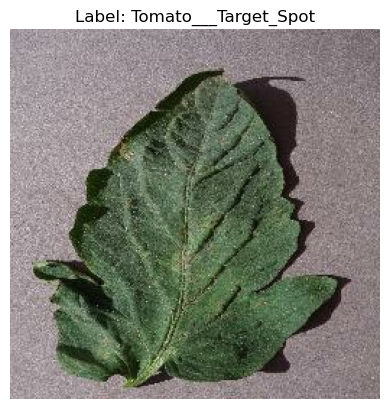

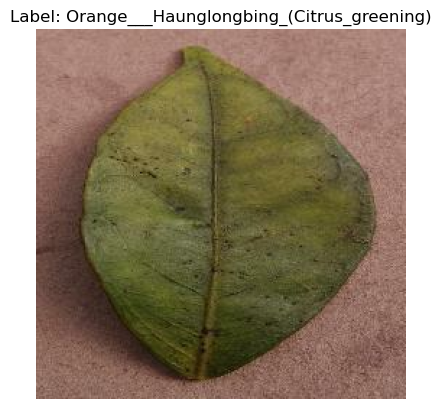

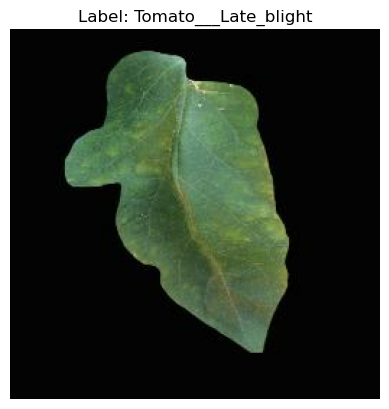

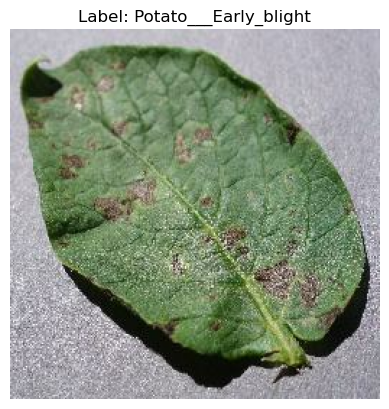

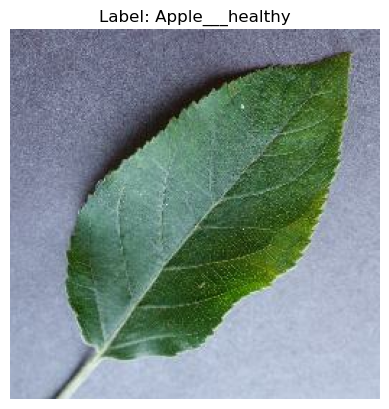

2025-04-18 16:46:32.260473: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the PlantVillage dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)
full_dataset = dataset['train']

# Visualize some sample images
for image, label in full_dataset.take(5):
    label_name = info.features['label'].int2str(label.numpy())
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis('off')
    plt.show()


In [2]:
label_names = info.features['label'].names
str2int = info.features['label'].str2int
int2str = info.features['label'].int2str

tomato_labels = [label for label in label_names if label.startswith('Tomato')]
tomato_label_ids = {name: str2int(name) for name in tomato_labels}
print(f"Tomato classes found: {tomato_labels}")

tomato_images_by_class = {name: [] for name in tomato_labels}
image_size = 224

for image, label in tfds.as_numpy(full_dataset):
    label_name = int2str(label)
    if label_name in tomato_images_by_class:
        # Resize using TensorFlow
        image_resized = tf.image.resize(image, (image_size, image_size)).numpy().astype(np.uint8)
        tomato_images_by_class[label_name].append((image_resized, label))


Tomato classes found: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


2025-04-18 16:46:58.818405: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
tomato_images_by_class = {name: [] for name in tomato_labels}

for image, label in tfds.as_numpy(full_dataset):
    label_name = int2str(label)
    if label_name in tomato_images_by_class:
        tomato_images_by_class[label_name].append((image, label))

class_sizes = {k: len(v) for k, v in tomato_images_by_class.items()}
min_class_size = min(class_sizes.values())
print(f"\nSmallest class: {min(class_sizes, key=class_sizes.get)} with {min_class_size} images")


Smallest class: Tomato___Tomato_mosaic_virus with 373 images


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from keras.utils import set_random_seed

SEED = 518
rng = np.random.default_rng(SEED)

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
set_random_seed(SEED)

# Balance the dataset by under-sampling to the smallest class size
balanced_samples = []
for class_name, samples in tomato_images_by_class.items():
    indices = rng.choice(len(samples), size=min_class_size, replace=False)
    balanced_samples.extend([samples[i] for i in indices])


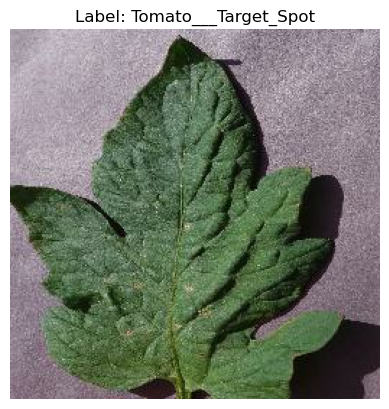

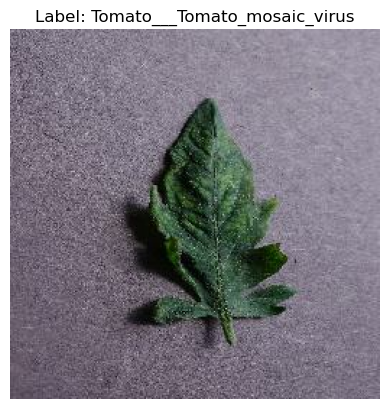

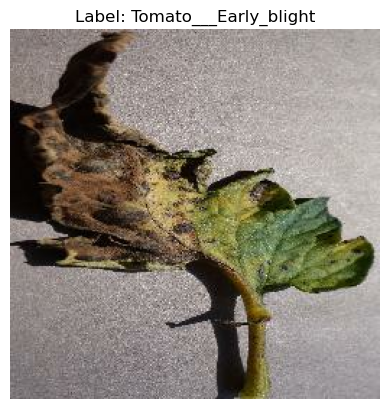

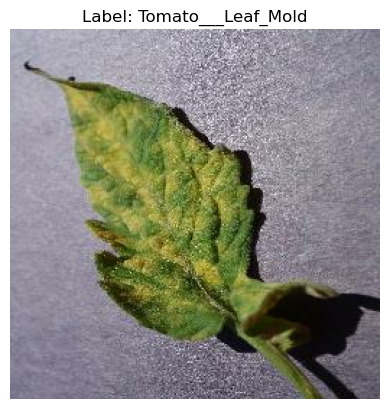

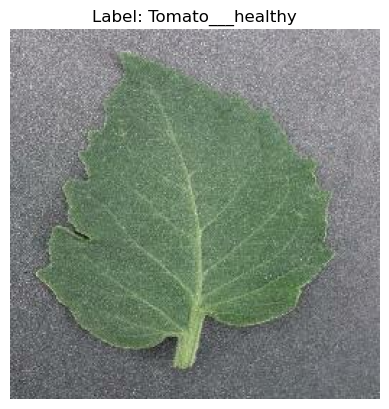

2025-04-18 16:47:09.128324: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
rng.shuffle(balanced_samples)

# Convert to tf.data.Dataset
balanced_tomato_ds = tf.data.Dataset.from_generator(
    lambda: iter(balanced_samples),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),  # image
        tf.TensorSpec(shape=(), dtype=tf.int64)                # label
    )
)
for image, label in balanced_tomato_ds.take(5):
    label_name = int2str(label.numpy())
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis("off")
    plt.show()


In [6]:
from collections import defaultdict
selected_indices_per_class = {}
balanced_samples = []

for class_name, samples in tomato_images_by_class.items():
    indices = rng.choice(len(samples), size=min_class_size, replace=False)
    selected_indices_per_class[class_name] = indices
    balanced_samples.extend([samples[i] for i in indices])

print("\n Selected indices per class (showing first 5 indices):")
for class_name, indices in selected_indices_per_class.items():
    print(f"{class_name}: {indices[:5]}")

balanced_tomato_ds = tf.data.Dataset.from_generator(
    lambda: iter(balanced_samples),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

# Check distribution
label_counts = defaultdict(int)
for _, label in balanced_tomato_ds:
    label_counts[label.numpy()] += 1

print("\n Class distribution in balanced dataset:")
for label_id, count in sorted(label_counts.items()):
    print(f"{int2str(label_id)}: {count} images")



 Selected indices per class (showing first 5 indices):
Tomato___Bacterial_spot: [1899 1074  996  179  687]
Tomato___Early_blight: [495 834 847 867 581]
Tomato___healthy: [ 209  316 1479  754  916]
Tomato___Late_blight: [ 211  804 1030  844  702]
Tomato___Leaf_Mold: [796 721 765 592 390]
Tomato___Septoria_leaf_spot: [ 860 1241 1769   47  536]
Tomato___Spider_mites Two-spotted_spider_mite: [ 242 1017 1577   90  597]
Tomato___Target_Spot: [ 196 1267  249 1101  232]
Tomato___Tomato_mosaic_virus: [225  14 136 299  11]
Tomato___Tomato_Yellow_Leaf_Curl_Virus: [4272  948 4729  183 1112]

 Class distribution in balanced dataset:
Tomato___Bacterial_spot: 373 images
Tomato___Early_blight: 373 images
Tomato___healthy: 373 images
Tomato___Late_blight: 373 images
Tomato___Leaf_Mold: 373 images
Tomato___Septoria_leaf_spot: 373 images
Tomato___Spider_mites Two-spotted_spider_mite: 373 images
Tomato___Target_Spot: 373 images
Tomato___Tomato_mosaic_virus: 373 images
Tomato___Tomato_Yellow_Leaf_Curl_Vir

In [7]:
# Set your target size
IMG_SIZE = 224

def preprocess_image(image, label):
    # Resize to (224, 224)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing
balanced_tomato_ds = balanced_tomato_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optional: shuffle and batch
BATCH_SIZE = 32
balanced_tomato_ds = balanced_tomato_ds.shuffle(1000, seed=SEED)
balanced_tomato_ds = balanced_tomato_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [8]:
from sklearn.model_selection import train_test_split

image_list = []
label_list = []

for image, label in balanced_tomato_ds.unbatch():
    image_list.append(image.numpy())
    label_list.append(label.numpy())

images_np = np.array(image_list)
labels_np = np.array(label_list)

print(f"✅ Shape of images: {images_np.shape}")
print(f"✅ Shape of labels: {labels_np.shape}")


✅ Shape of images: (3730, 224, 224, 3)
✅ Shape of labels: (3730,)


In [9]:
# First split: 80% train, 20% temp
x_train, x_temp, y_train, y_temp = train_test_split(
    images_np, labels_np, test_size=0.2, stratify=labels_np, random_state=SEED
)

# Second split: 50/50 of temp → 10% val, 10% test
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)


In [10]:
print(f"x_train: {x_train.shape}, x_val: {x_val.shape}, x_test: {x_test.shape}")


x_train: (2984, 224, 224, 3), x_val: (373, 224, 224, 3), x_test: (373, 224, 224, 3)


In [11]:
# Rebuild tf.data.Dataset objects from arrays
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Batch + prefetch
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


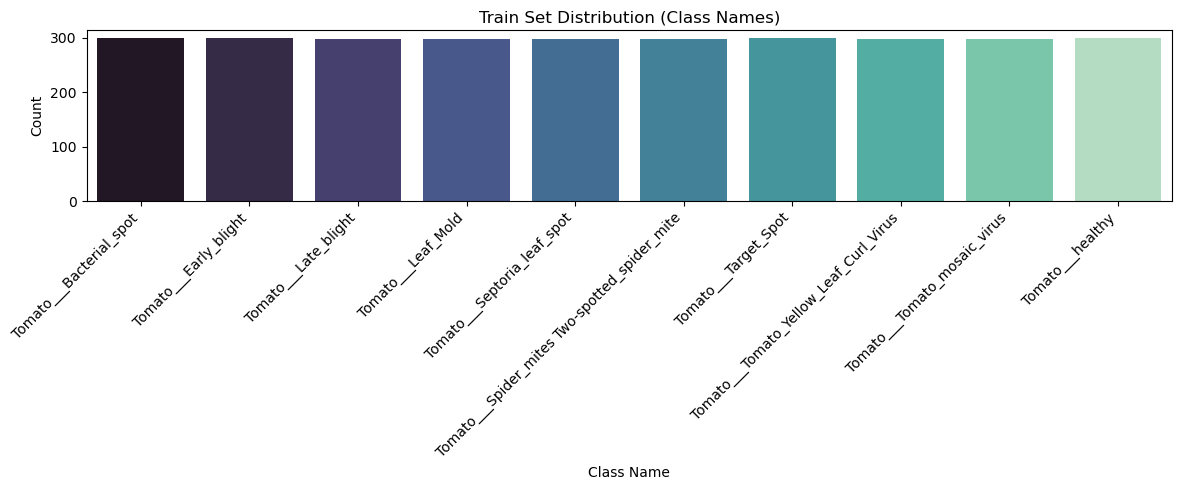

Tomato___Bacterial_spot                          299
Tomato___Early_blight                            299
Tomato___Late_blight                             298
Tomato___Leaf_Mold                               298
Tomato___Septoria_leaf_spot                      298
Tomato___Spider_mites Two-spotted_spider_mite    298
Tomato___Target_Spot                             299
Tomato___Tomato_Yellow_Leaf_Curl_Virus           298
Tomato___Tomato_mosaic_virus                     298
Tomato___healthy                                 299
Name: count, dtype: int64


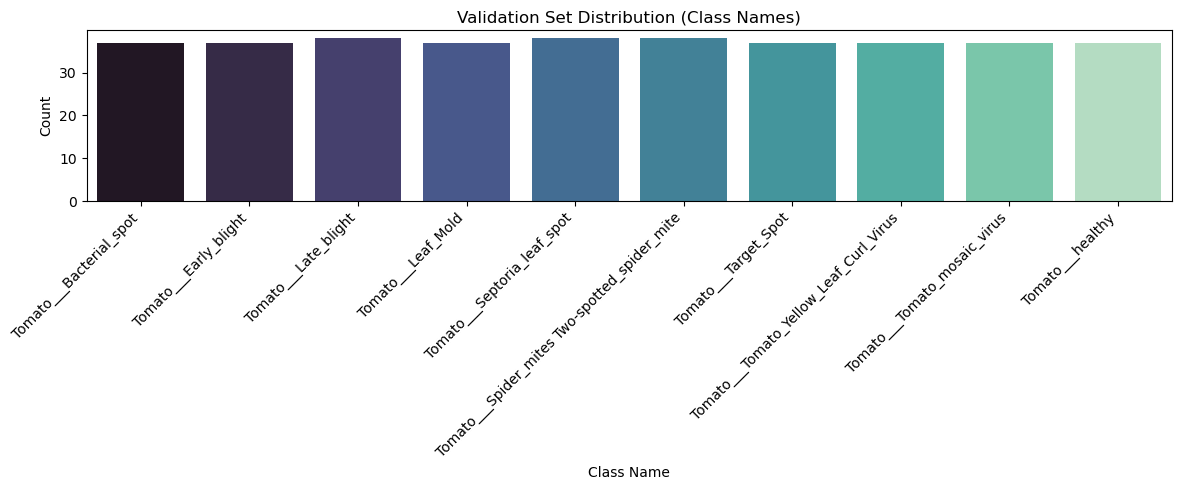

Tomato___Bacterial_spot                          37
Tomato___Early_blight                            37
Tomato___Late_blight                             38
Tomato___Leaf_Mold                               37
Tomato___Septoria_leaf_spot                      38
Tomato___Spider_mites Two-spotted_spider_mite    38
Tomato___Target_Spot                             37
Tomato___Tomato_Yellow_Leaf_Curl_Virus           37
Tomato___Tomato_mosaic_virus                     37
Tomato___healthy                                 37
Name: count, dtype: int64


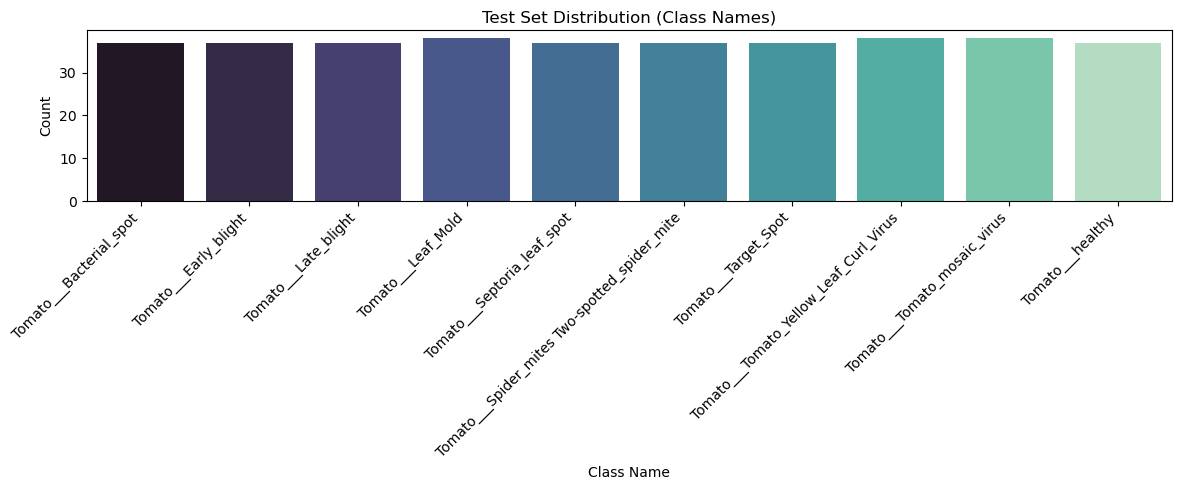

Tomato___Bacterial_spot                          37
Tomato___Early_blight                            37
Tomato___Late_blight                             37
Tomato___Leaf_Mold                               38
Tomato___Septoria_leaf_spot                      37
Tomato___Spider_mites Two-spotted_spider_mite    37
Tomato___Target_Spot                             37
Tomato___Tomato_Yellow_Leaf_Curl_Virus           38
Tomato___Tomato_mosaic_virus                     38
Tomato___healthy                                 37
Name: count, dtype: int64


In [12]:
def plot_label_distribution_named(labels, title):
    # Convert numeric labels to class names
    label_names = [int2str(label) for label in labels]
    label_counts = pd.Series(label_names).value_counts().sort_index()
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='mako')
    plt.title(title)
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(label_counts)

# Plot with class names
plot_label_distribution_named(y_train, "Train Set Distribution (Class Names)")
plot_label_distribution_named(y_val, "Validation Set Distribution (Class Names)")
plot_label_distribution_named(y_test, "Test Set Distribution (Class Names)")


In [13]:
# Make a deep copy of your train/val/test image arrays and labels
x_train_svm = x_train.copy()
x_val_svm = x_val.copy()
x_test_svm = x_test.copy()

y_train_svm = y_train.copy()
y_val_svm = y_val.copy()
y_test_svm = y_test.copy()


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance for augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    brightness_range=[0.4, 1.5],
    zoom_range=[0.5, 1.5],
    shear_range=25,
    fill_mode='nearest'
)

# Fit the data generator on your training images (for normalization)
datagen.fit(x_train)

In [16]:
# Create a mapping for the original labels to the new range [0, 9]
label_mapping = {old_label: new_label for new_label, old_label in enumerate(range(28, 38))}

# Apply this mapping to your training and validation labels
y_train_mapped = np.array([label_mapping[label] for label in y_train])
y_val_mapped = np.array([label_mapping[label] for label in y_val])
y_test_mapped = np.array([label_mapping[label] for label in y_test])

# Now, let's check if the new labels are correctly mapped
unique_train_labels = np.unique(y_train_mapped)
print(f"Unique labels in y_train after re-encoding: {unique_train_labels}")


Unique labels in y_train after re-encoding: [0 1 2 3 4 5 6 7 8 9]


In [17]:
# Check the unique labels in your dataset
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")


Unique labels in the training set: [28 29 30 31 32 33 34 35 36 37]


In [21]:
print("Original y_train labels:", np.unique(y_train))
print("Mapped y_train_mapped labels:", np.unique(y_train_mapped))

Original y_train labels: [28 29 30 31 32 33 34 35 36 37]
Mapped y_train_mapped labels: [0 1 2 3 4 5 6 7 8 9]


In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# Set image input shape
img_width, img_height = 224, 224

# Map only the tomato class labels to range [0–9]
tomato_label_ids = sorted(np.unique(y_train))
label_id_to_idx = {original: new for new, original in enumerate(tomato_label_ids)}
idx_to_label_id = {v: k for k, v in label_id_to_idx.items()}

y_train_mapped = np.array([label_id_to_idx[label] for label in y_train])
y_val_mapped = np.array([label_id_to_idx[label] for label in y_val])
y_test_mapped = np.array([label_id_to_idx[label] for label in y_test])


# Load ResNet50
resnet50 = ResNet50(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')
for layer in resnet50.layers:
    layer.trainable = False

    
# Build model with 10 output classes
model = Sequential([
    resnet50,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # for 10 tomato classes
])
model.summary()

# Compile model 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ModelCheckpoint('resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(restore_best_weights = True,monitor='val_loss', patience=3, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
]

# Prepare datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_mapped)).batch(32).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_mapped)).batch(32)

# Dummy forward pass
_ = model(tf.zeros((1, img_width, img_height, 3)))

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,614,154 (482.99 MB)

 Trainable params: 103,026,442 (393.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.1249 - loss: 10.5032
Epoch 1: val_loss improved from inf to 2.32728, saving model to resnet_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 798ms/step - accuracy: 0.1252 - loss: 10.4495 - val_accuracy: 0.1823 - val_loss: 2.3273 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.2465 - loss: 2.1515
Epoch 2: val_loss improved from 2.32728 to 1.91726, saving model to resnet_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 752ms/step - accuracy: 0.2468 - loss: 2.1507 - val_accuracy: 0.3298 - val_loss: 1.9173 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.3495 - loss: 1.8538
Epoch 3: val_loss improved from 1.91726 to 1.76996, saving model to resnet_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 741ms/step - accuracy: 0.3497 - loss: 1.8533 - val_accuracy: 0.3458 - val_loss: 1.7700 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - acc

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step
 Found 63 misclassified samples.


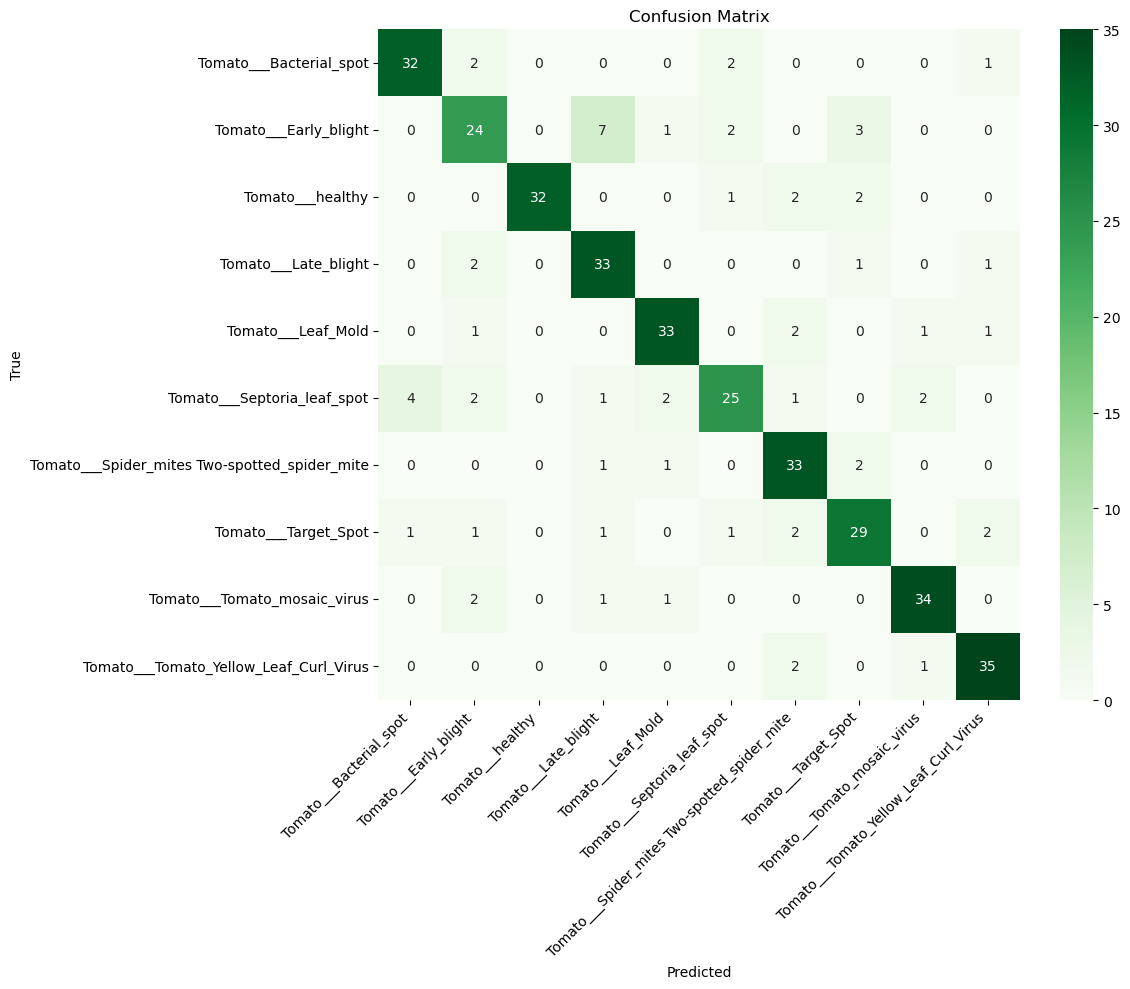


Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.86      0.86      0.86        37
                        Tomato___Early_blight       0.71      0.65      0.68        37
                             Tomato___healthy       1.00      0.86      0.93        37
                         Tomato___Late_blight       0.75      0.89      0.81        37
                           Tomato___Leaf_Mold       0.87      0.87      0.87        38
                  Tomato___Septoria_leaf_spot       0.81      0.68      0.74        37
Tomato___Spider_mites Two-spotted_spider_mite       0.79      0.89      0.84        37
                         Tomato___Target_Spot       0.78      0.78      0.78        37
                 Tomato___Tomato_mosaic_virus       0.89      0.89      0.89        38
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.88      0.92      0.90        38

                

In [33]:

y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = y_test_mapped  # Use mapped test labels!

misclassified_idxs = np.where(y_true != y_pred_classes)[0]
print(f" Found {len(misclassified_idxs)} misclassified samples.")

class_names = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:\n")
print(report)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'\nAccuracy: {accuracy:.4f}')





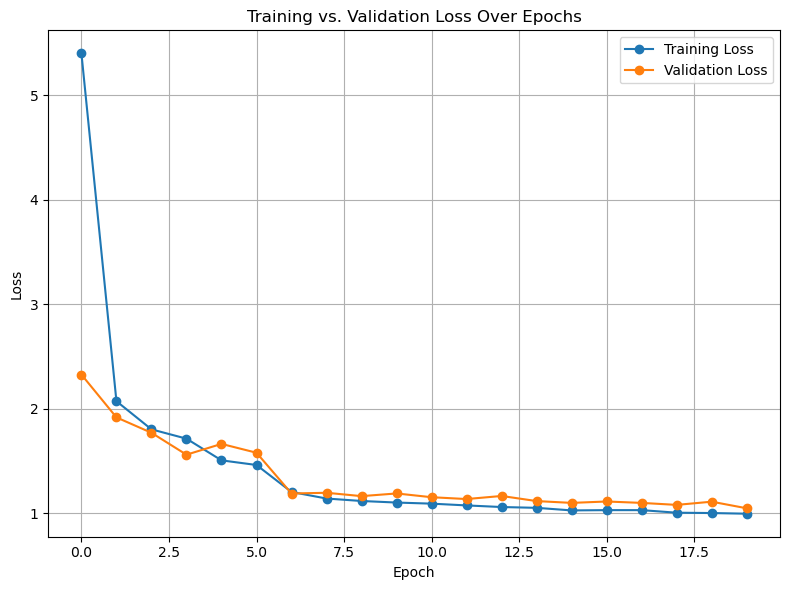

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


img_width, img_height, channels = 224, 224, 3

vgg19 = VGG19(
    include_top=False,
    input_shape=(img_width, img_height, channels),
    weights='imagenet'
)

# Freeze VGG19 layers
for layer in vgg19.layers:
    layer.trainable = False

# build the full model
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  


model.summary()


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


checkpoint = ModelCheckpoint('vgg19_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(restore_best_weights = True, monitor='val_loss', patience=3, verbose=1) # 3 worse, than it stops
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
callbacks = [checkpoint, earlystop, reduceLR]


train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_mapped)).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_mapped)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

# cross validation to test a bnuch of models and see which is performing best and pick one. data preprocessing ***********

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,980,490 (175.40 MB)

 Trainable params: 25,956,106 (99.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2777 - loss: 4.4417
Epoch 1: val_loss improved from inf to 0.99443, saving model to vgg19_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.2795 - loss: 4.4202 - val_accuracy: 0.6488 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7196 - loss: 0.8334
Epoch 2: val_loss improved from 0.99443 to 0.70929, saving model to vgg19_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7198 - loss: 0.8328 - val_accuracy: 0.7587 - val_loss: 0.7093 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8008 - loss: 0.6112
Epoch 3: val_loss did not improve from 0.70929
94/94 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8009 - loss: 0.6107 - val_accuracy: 0.7694 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8337 - loss: 0.4645
Epoch 4: val_loss improved from 0

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 929ms/step
 Found 39 misclassified samples.


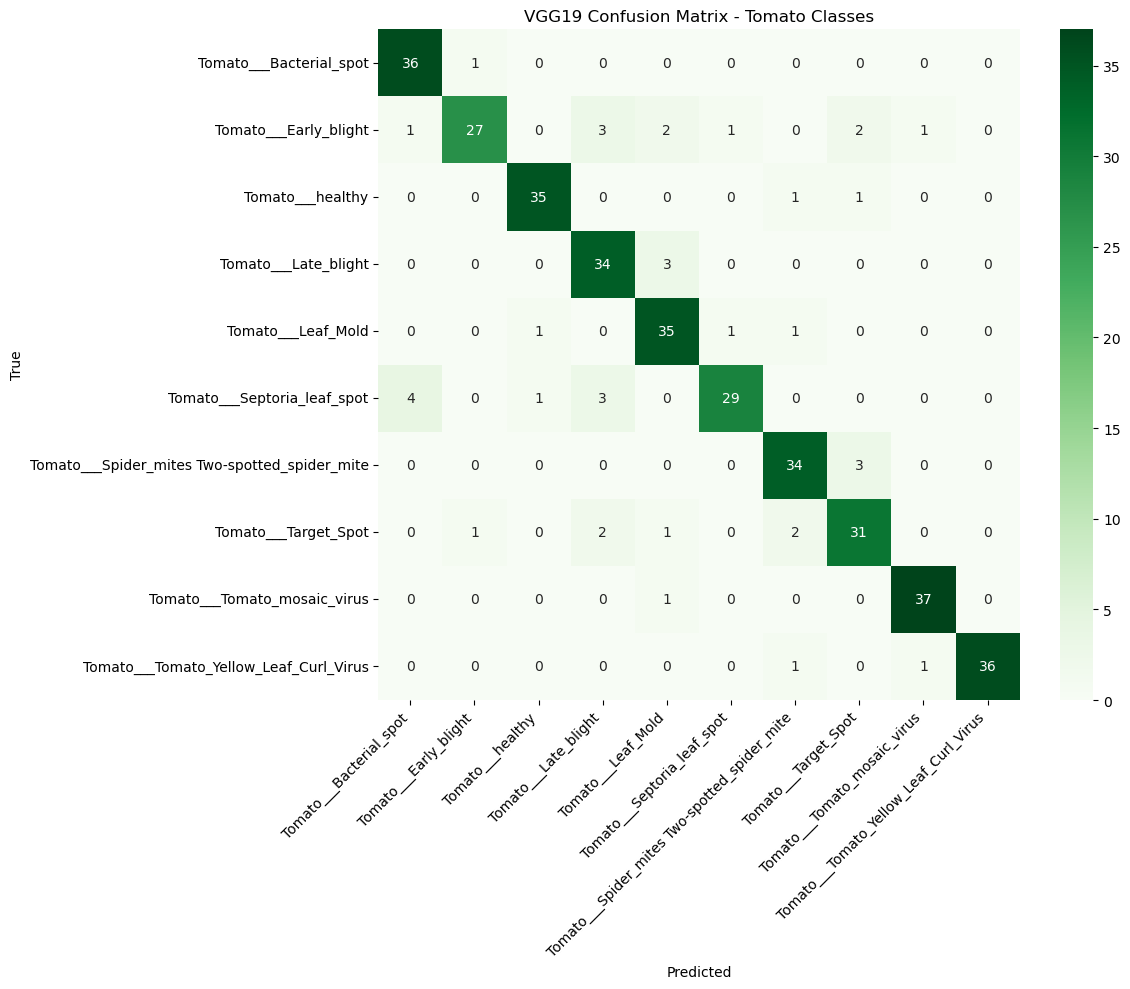

Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.88      0.97      0.92        37
                        Tomato___Early_blight       0.93      0.73      0.82        37
                             Tomato___healthy       0.95      0.95      0.95        37
                         Tomato___Late_blight       0.81      0.92      0.86        37
                           Tomato___Leaf_Mold       0.83      0.92      0.88        38
                  Tomato___Septoria_leaf_spot       0.94      0.78      0.85        37
Tomato___Spider_mites Two-spotted_spider_mite       0.87      0.92      0.89        37
                         Tomato___Target_Spot       0.84      0.84      0.84        37
                 Tomato___Tomato_mosaic_virus       0.95      0.97      0.96        38
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.95      0.97        38

                 

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = y_test_mapped  # use mapped version (0–9)

misclassified_idxs = np.where(y_true != y_pred_classes)[0]
print(f" Found {len(misclassified_idxs)} misclassified samples.")

class_names = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10)) # try 10, 8
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',#
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('VGG19 Confusion Matrix - Tomato Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)


accuracy = accuracy_score(y_true, y_pred_classes)
print(f'\n Test Accuracy: {accuracy:.4f}')


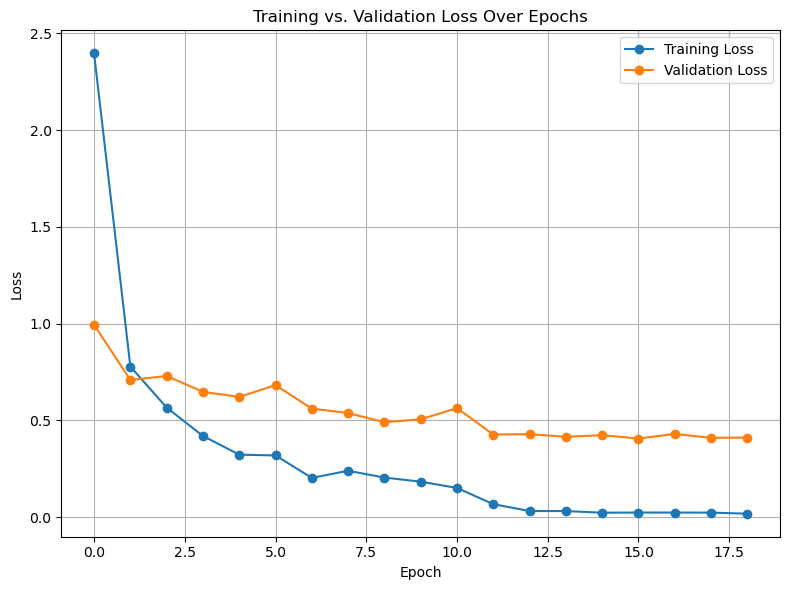

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.applications import InceptionV3

img_width, img_height, channels = 224, 224, 3
num_classes = 10

inception_v3 = InceptionV3(
    include_top=False,
    input_shape=(img_width, img_height, channels),
    weights='imagenet'
)

for layer in inception_v3.layers:
    layer.trainable = False

model = Sequential([
    inception_v3,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


callbacks = [
    ModelCheckpoint('inceptionv3_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(restore_best_weights = True,  monitor='val_loss', patience=3, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
]


train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_mapped)).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_mapped)).batch(32).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    52,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497,578 (284.19 MB)

 Trainable params: 52,694,794 (201.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.2789 - loss: 18.7345
Epoch 1: val_loss improved from inf to 1.11397, saving model to inceptionv3_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 484ms/step - accuracy: 0.2801 - loss: 18.6290 - val_accuracy: 0.6220 - val_loss: 1.1140 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6600 - loss: 1.0581
Epoch 2: val_loss improved from 1.11397 to 0.91272, saving model to inceptionv3_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - accuracy: 0.6602 - loss: 1.0573 - val_accuracy: 0.6863 - val_loss: 0.9127 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7291 - loss: 0.8087
Epoch 3: val_loss improved from 0.91272 to 0.89193, saving model to inceptionv3_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 444ms/step - accuracy: 0.7291 - loss: 0.8087 - val_accuracy: 0.7078 - val_loss: 0.8919 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step
 Found 63 misclassified samples.


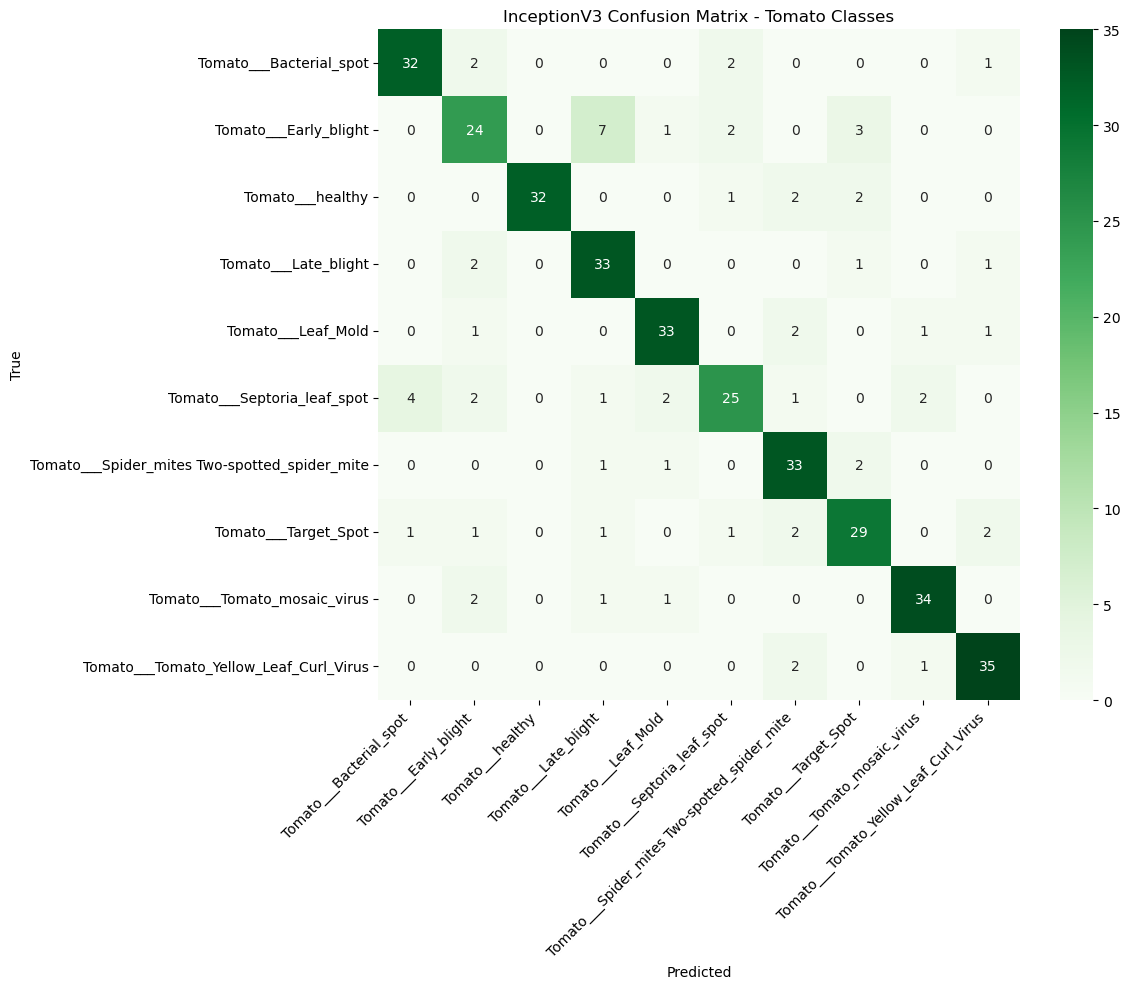


 Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.86      0.86      0.86        37
                        Tomato___Early_blight       0.71      0.65      0.68        37
                             Tomato___healthy       1.00      0.86      0.93        37
                         Tomato___Late_blight       0.75      0.89      0.81        37
                           Tomato___Leaf_Mold       0.87      0.87      0.87        38
                  Tomato___Septoria_leaf_spot       0.81      0.68      0.74        37
Tomato___Spider_mites Two-spotted_spider_mite       0.79      0.89      0.84        37
                         Tomato___Target_Spot       0.78      0.78      0.78        37
                 Tomato___Tomato_mosaic_virus       0.89      0.89      0.89        38
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.88      0.92      0.90        38

               

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = y_test_mapped

misclassified_idxs = np.where(y_true != y_pred_classes)[0]
print(f" Found {len(misclassified_idxs)} misclassified samples.")

class_names = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('InceptionV3 Confusion Matrix - Tomato Classes')
plt.xticks(rotation=45, ha ='right')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\n Classification Report:\n")
print(report)

acc = accuracy_score(y_true, y_pred_classes)
print(f"\n Test Accuracy: {acc:.4f}")




# inception_v3.summary()

# ReduceLROnPlateau 
# Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
# This scheduler reads a metrics quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SVM Modeling

In [14]:
## flatten the data so we can build the SVM model (aka svc)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## cehck if split is before augmentation
# Combine validation and test sets for final evaluation
x_test = np.concatenate([x_val_svm, x_test_svm], axis=0)
y_test = np.concatenate([y_val_svm, y_test_svm], axis=0)

# Flatten image arrays
x_train_flat = x_train_svm.reshape(x_train_svm.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

## scaling the features (need to do this so the data meets the necessary assumptions to build the SVM model) whatever that means
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)



In [15]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
## conducting PCA analysis in order reduce the dimensions of the image data
## if this step is not done, building a SVM model without using dimension reduction is computationally expensive
pca = PCA(n_components=100, random_state= SEED)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)



In [70]:

# Flattened images have a lot of redundant info.
# High-dimensional data can cause overfitting, long training times, and poor generalization.
# PCA helps by reducing dimensions while preserving most of the variance (signal)


# to optimize your SVM model using cross-validation
# Define parameter grid
# param_grid = {
#     'pca__n_components': [0.1, 1, 10, 50, 100, 200]y,  # You can expand this
#     'svm__C': [0.1, 1, 10],
#     'svm__kernel': ['linear', 'rbf'],
#     'svm__gamma': ['scale', 'auto']
# }

param_grid = {
    'C': [ 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly']
}


svc = svm.SVC(probability=True)
model_svm_reduced = GridSearchCV(svc, param_grid, cv=10, verbose=2, n_jobs=-1)

np.random.seed(SEED)
model_svm_reduced.fit(x_train_pca, y_train_svm)

print("Best parameters:", model_svm_reduced.best_params_)  


Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


In [67]:

# Final model
best_params = model_svm_reduced.best_params_
final_svm_reduced = svm.SVC(
    C=best_params['C'],
    gamma=best_params['gamma'],
    kernel=best_params['kernel'],
    probability=True
)
final_svm_reduced.fit(x_train_pca, y_train_svm)


SVC(C=0.001, gamma=0.001, kernel='poly', probability=True)

In [68]:

#Predict + Evaluate
y_pred = final_svm_reduced.predict(x_test_pca)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.6581769436997319

Classification Report:
               precision    recall  f1-score   support

          28       0.49      0.80      0.61        74
          29       0.50      0.31      0.38        74
          30       0.75      0.85      0.80        74
          31       0.74      0.47      0.57        75
          32       0.77      0.73      0.75        75
          33       0.75      0.53      0.62        75
          34       0.69      0.55      0.61        75
          35       0.51      0.70      0.59        74
          36       0.67      0.88      0.76        75
          37       0.86      0.76      0.81        75

    accuracy                           0.66       746
   macro avg       0.68      0.66      0.65       746
weighted avg       0.68      0.66      0.65       746



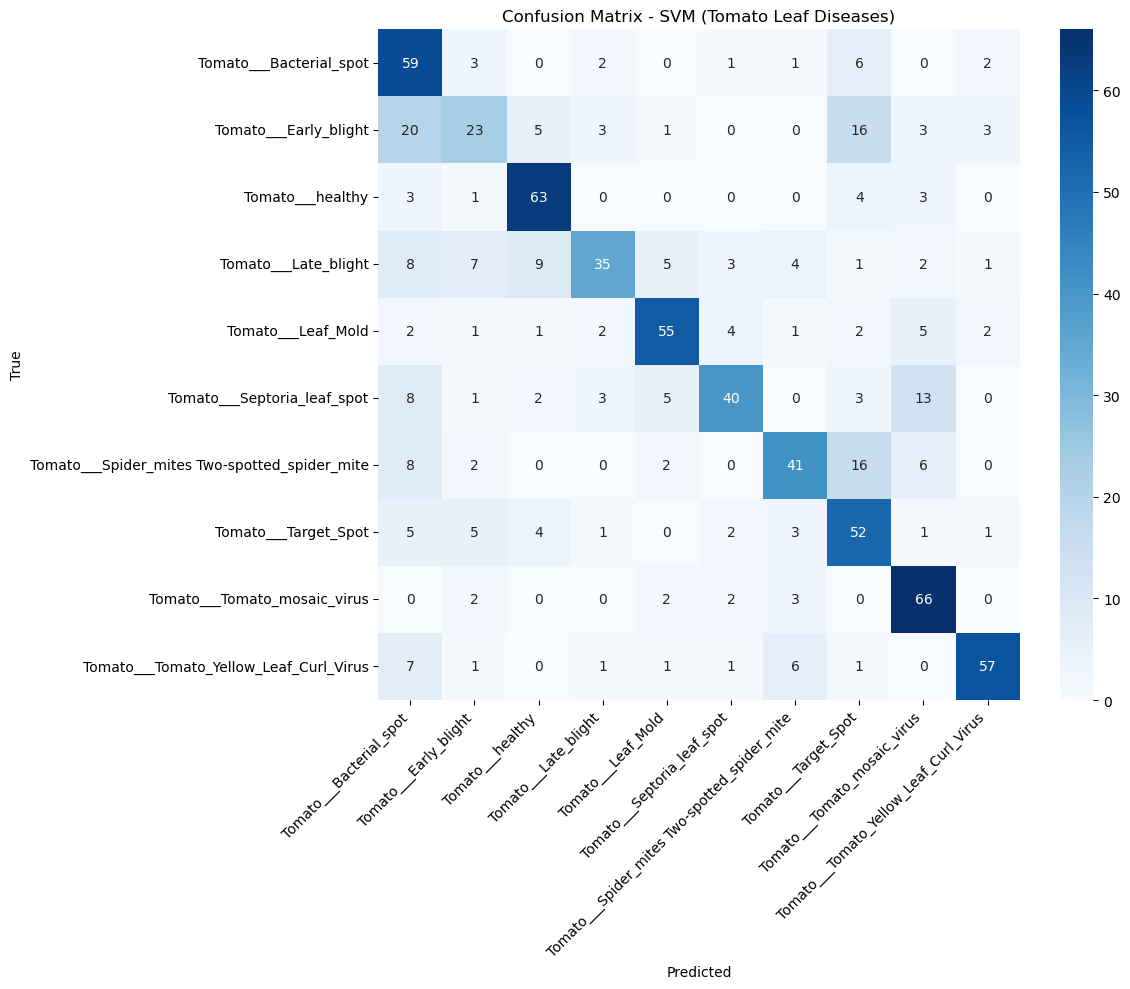


 Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.49      0.80      0.61        74
                        Tomato___Early_blight       0.50      0.31      0.38        74
                             Tomato___healthy       0.75      0.85      0.80        74
                         Tomato___Late_blight       0.74      0.47      0.57        75
                           Tomato___Leaf_Mold       0.77      0.73      0.75        75
                  Tomato___Septoria_leaf_spot       0.75      0.53      0.62        75
Tomato___Spider_mites Two-spotted_spider_mite       0.69      0.55      0.61        75
                         Tomato___Target_Spot       0.51      0.70      0.59        74
                 Tomato___Tomato_mosaic_virus       0.67      0.88      0.76        75
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.86      0.76      0.81        75

               

In [69]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your predicted and true labels from the SVM
y_pred = final_svm_reduced.predict(x_test_pca)  # predicted labels
y_true = y_test  # true labels (already mapped to 0–9 range)

class_names = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM (Tomato Leaf Diseases)')
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, target_names=class_names)
print("\n Classification Report:\n")
print(report)

accuracy = accuracy_score(y_true, y_pred)
print(f'\nAccuracy: {accuracy:.4f}')
